<a href="https://colab.research.google.com/github/Rainniee/Neural-Networks-AI/blob/master/Experiment1_RNN%20Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import division
from __future__ import print_function

import pandas as pd
import numpy as np

import itertools
import os

import nltk
from nltk.corpus import stopwords
from sklearn.metrics import confusion_matrix, accuracy_score

from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelBinarizer, LabelEncoder


%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.keras.datasets import imdb
from tensorflow import keras
from keras.layers import Embedding, Flatten, Dense, SimpleRNN, LSTM, Activation, Dropout
from keras.layers import LSTM, CuDNNLSTM

from keras.models import Sequential
from keras.models import load_model
from keras.preprocessing import text, sequence
from keras import utils
from tensorflow.keras.callbacks import EarlyStopping

# This code was tested with TensorFlow v1.4
print("You have TensorFlow version", tf.__version__)

from distutils.version import LooseVersion as LV
from keras import __version__
from keras import backend as K

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

import seaborn as sns
sns.set()

Using TensorFlow backend.


You have TensorFlow version 1.13.1


In [2]:
from google.colab import files
upload = files.upload()

Saving cleanedfinancial_data.csv to cleanedfinancial_data.csv


In [0]:
financial_data = pd.read_csv('cleanedfinancial_data.csv')
financial_data.drop(columns="Unnamed: 0", inplace=True)

financial_data.iloc[2,1]

"Well, we need to bring the Shanghai factory online. I think that's the biggest driver for getting to 500K plus a year. Our car is just very expensive going into China. We've got import duties. We've got transport costs. We've got higher-cost labor here. And we've never been eligible for any of the EV tax credits. A lot of people sort of dependent on incentives. In fact, we are [indiscernible] EVs, we have the least access to incentives. It's pretty crazy because there's so many companies that - countries that have put price caps on the EV incentive, which affects Tesla. And in China, which is the biggest market for EVs, we've never had any subsidies or tax incentives for vehicles."

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

financial_data.shape[0]

1649

In [0]:
import re
import nltk

nltk.download('punkt')
from nltk.tokenize import word_tokenize as wt 

nltk.download('stopwords')
from nltk.corpus import stopwords

from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
financial_data.shape

(1649, 2)

In [0]:
data = []

financial_test = financial_data[financial_data['sentiment'] != 'neutral']

for i in range(financial_test.shape[0]):
    sms = financial_test.iloc[i, 1]

    # remove non alphabatic characters
    sms = re.sub('[^A-Za-z]', ' ', sms)

    # make words lowercase, because Go and go will be considered as two words
    sms = sms.lower()

    # tokenising
    tokenized_sms = wt(sms)

    # remove stop words and stemming
 
    sms_processed = []
    for word in tokenized_sms:
        if word not in set(stopwords.words('english')):
            sms_processed.append(stemmer.stem(word))

    sms_text = " ".join(sms_processed)
    data.append(sms_text)

In [0]:
financial_test['sentiment'] = financial_test['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

X = tokenizer.texts_to_matrix(financial_test['text'].tolist(), mode='freq')
y = np.asarray(financial_test['sentiment'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [0]:
# split train and test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [0]:
# number of most-frequent words to use
nb_words = 10000
# cut texts after this number of words
maxlen = 2000

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(X_train, maxlen=maxlen)
x_test = sequence.pad_sequences(X_test, maxlen=maxlen)

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

Pad sequences (samples x time)
x_train shape: (648, 2000)
x_test shape: (163, 2000)
y_train shape: (648,)
y_test shape: (163,)


In [0]:
print("First review in the training set:\n", x_train[0], "length:", len(x_train[0]), "class:", y_train[0])

First review in the training set:
 [0 0 0 ... 0 0 0] length: 2000 class: 1


In [0]:
# model parameters:
embedding_dims = 50
lstm_units = 32

print('Build model...')
model = Sequential()

model.add(Embedding(nb_words,
                    embedding_dims,
                    input_length=maxlen))
model.add(Dropout(0.2))

# model.add(LSTM(lstm_units))
# running on a GPU:
model.add(CuDNNLSTM(lstm_units))

# To stack multiple RNN layers, all RNN layers except the last one need
# to have "return_sequences=True".  An example of using two RNN layers:
#model.add(LSTM(lstm_units, return_sequences=True))
#model.add(LSTM(lstm_units))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
print(model.summary())

Build model...
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2000, 50)          500000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 2000, 50)          0         
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 32)                10752     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 510,785
Trainable params: 510,785
Non-trainable params: 0
_________________________________________________________________
None


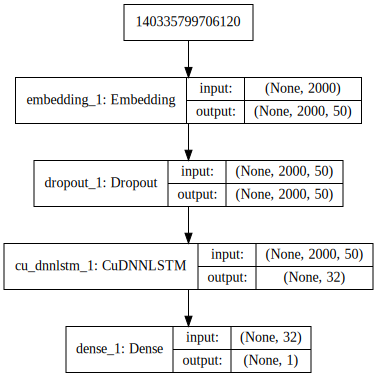

In [0]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [0]:
%%time
epochs = 10
validation_split = 0.2

history = model.fit(x_train, y_train, batch_size=128,
          epochs=epochs, 
          validation_split=validation_split)

Instructions for updating:
Use tf.cast instead.
Train on 518 samples, validate on 130 samples
Epoch 1/10
518/518 [==============================] - 6s 11ms/step - loss: 0.6492 - acc: 0.7278 - val_loss: 0.6099 - val_acc: 0.7769
Epoch 2/10
518/518 [==============================] - 1s 2ms/step - loss: 0.5522 - acc: 0.8185 - val_loss: 0.5324 - val_acc: 0.7769
Epoch 3/10
518/518 [==============================] - 1s 2ms/step - loss: 0.4760 - acc: 0.8185 - val_loss: 0.5363 - val_acc: 0.7769
Epoch 4/10
518/518 [==============================] - 1s 2ms/step - loss: 0.4746 - acc: 0.8185 - val_loss: 0.5655 - val_acc: 0.7769
Epoch 5/10
518/518 [==============================] - 1s 2ms/step - loss: 0.4780 - acc: 0.8185 - val_loss: 0.5308 - val_acc: 0.7769
Epoch 6/10
518/518 [==============================] - 1s 2ms/step - loss: 0.4780 - acc: 0.8185 - val_loss: 0.5310 - val_acc: 0.7769
Epoch 7/10
518/518 [==============================] - 1s 2ms/step - loss: 0.4764 - acc: 0.8185 - val_loss: 0.5380

In [0]:
score, acc = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (acc*100))
print("Test score: %.2f%%" % (score*100))

Accuracy: 79.14%
Test score: 51.39%


0.7914110429447853
              precision    recall  f1-score   support

         pos       0.00      0.00      0.00        34
         neg       0.79      1.00      0.88       129

   micro avg       0.79      0.79      0.79       163
   macro avg       0.40      0.50      0.44       163
weighted avg       0.63      0.79      0.70       163

[[  0  34]
 [  0 129]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


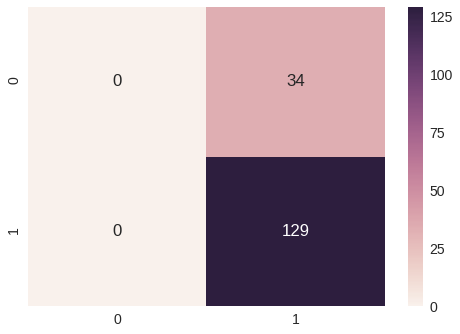

In [0]:
import pandas as pd
import seaborn as sns

from sklearn.metrics import classification_report,confusion_matrix
y_pred = model.predict_classes(np.array(x_test))

from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred))
target_names = ['pos', 'neg']
cnf_matrix_test = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred, target_names=target_names))
print(cnf_matrix_test)

df_cm = pd.DataFrame(cnf_matrix_test, range(2), range(2))

sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, fmt='d')

In [0]:
TP = cnf_matrix_test[1, 1]
TN = cnf_matrix_test[0, 0]
FP = cnf_matrix_test[0, 1]
FN = cnf_matrix_test[1, 0]

classification_error = (FP + FN) / float(TP + TN + FP + FN)
print(classification_error)

0.2085889570552147


In [0]:
import pandas as pd 
from keras.models import Sequential,Model
from keras.layers import Embedding, SimpleRNN,Input
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras.layers import Dense,Dropout
from keras.layers import Embedding, Flatten, Dense,Conv1D,MaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn import preprocessing
import numpy as np
import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import itertools    
import seaborn as sns
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical
from collections import Counter

In [3]:
data = pd.read_csv("cleanedfinancial_data.csv")
data.head()

,sentiment,text
0,neutral,"Good day, ladies and gentlemen, and welcome to..."
1,negative,I'm not sure. I think Model T was a little bit...
2,negative,"Well, we need to bring the Shanghai factory on..."
3,neutral,So it's - it is eligible for that. But it soun...
4,positive,The demand for - the demand for Model 3 is ins...


In [0]:
data_inputs =  data["text"].get_values()
# Convert sentiments into 0,1,2
sent = {'positive': 1,'negative': 0,'neutral': 2} 
data.sentiment = [sent[item] for item in data.sentiment]

In [0]:
data_labels = data.sentiment

In [8]:
tokenizer = Tokenizer(nb_words=2000)
tokenizer.fit_on_texts(data_inputs)
sequences = tokenizer.texts_to_sequences(data_inputs)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=1000)

labels = keras.utils.to_categorical(np.asarray(data_labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/text.py:178: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


Found 6376 unique tokens.
Shape of data tensor: (1649, 1000)
Shape of label tensor: (1649, 3)


In [0]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(.20 * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

In [17]:
# model parameters:
embedding_dims = 50
lstm_units = 32
# number of most-frequent words to use
nb_words = 10000
# cut texts after this number of words
maxlen = 1000


print('Build model...')
model = Sequential()

model.add(Embedding(nb_words,
                    embedding_dims,
                    input_length=maxlen))
model.add(Dropout(0.2))

# model.add(LSTM(lstm_units))
# running on a GPU:
model.add(CuDNNLSTM(lstm_units))

# To stack multiple RNN layers, all RNN layers except the last one need
# to have "return_sequences=True".  An example of using two RNN layers:
#model.add(LSTM(lstm_units, return_sequences=True))
#model.add(LSTM(lstm_units))

model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adadelta',
              loss='poisson',
              metrics=['accuracy'])

print(model.summary())

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 1000, 50)          500000    
_________________________________________________________________
dropout_3 (Dropout)          (None, 1000, 50)          0         
_________________________________________________________________
cu_dnnlstm_3 (CuDNNLSTM)     (None, 32)                10752     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 99        
Total params: 510,851
Trainable params: 510,851
Non-trainable params: 0
_________________________________________________________________
None


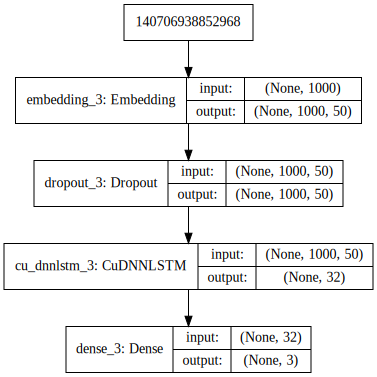

In [18]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [19]:
%%time
epochs = 10
validation_split = 0.2

history = model.fit(x_train, y_train, batch_size=128,
          epochs=epochs, 
          validation_split=validation_split)

Instructions for updating:
Use tf.cast instead.
Train on 1056 samples, validate on 264 samples
Epoch 1/10
1056/1056 [==============================] - 6s 6ms/step - loss: 0.6903 - acc: 0.4839 - val_loss: 0.6793 - val_acc: 0.4924
Epoch 2/10
1056/1056 [==============================] - 1s 975us/step - loss: 0.6650 - acc: 0.5123 - val_loss: 0.6529 - val_acc: 0.4924
Epoch 3/10
1056/1056 [==============================] - 1s 977us/step - loss: 0.6369 - acc: 0.5123 - val_loss: 0.6353 - val_acc: 0.4924
Epoch 4/10
1056/1056 [==============================] - 1s 979us/step - loss: 0.6175 - acc: 0.5464 - val_loss: 0.6238 - val_acc: 0.5795
Epoch 5/10
1056/1056 [==============================] - 1s 968us/step - loss: 0.6100 - acc: 0.5966 - val_loss: 0.6179 - val_acc: 0.5720
Epoch 6/10
1056/1056 [==============================] - 1s 967us/step - loss: 0.5987 - acc: 0.6222 - val_loss: 0.6166 - val_acc: 0.5682
Epoch 7/10
1056/1056 [==============================] - 1s 969us/step - loss: 0.5961 - acc:

In [21]:
loss, acc = model.evaluate(x_val,y_val, verbose = 2, batch_size = 128)
print("Validation Loss: %.2f" % (loss))
print("Validation Accuracy: %.2f" % (acc*100))

Validation Loss: 0.62
Validation Accuracy: 59.88


[[  1  36   3]
 [  8 108   6]
 [ 11  77  79]]


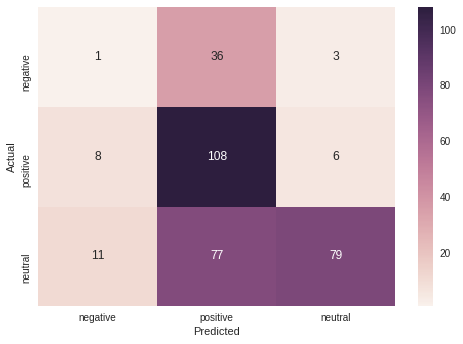

In [22]:
# Predicting the Test set results
y_pred = model.predict(x_val)
# cutoff 0.5
y_pred = (y_pred > 0.5)

y_pred = y_pred.astype(int)


# Confusion matrix 
cm = confusion_matrix(y_val.argmax(axis=1), y_pred.argmax(axis=1))
print(cm)

LABELS = ['negative', 'positive','neutral']
sns.heatmap(cm, annot=True, xticklabels=LABELS, yticklabels=LABELS, fmt='g')
xl = plt.xlabel("Predicted")
yl = plt.ylabel("Actual")

In [26]:
# model parameters:
embedding_dims = 50
lstm_units = 128
# number of most-frequent words to use
nb_words = 10000
# cut texts after this number of words
maxlen = 1000

print('Build 2nd model...')
model = Sequential()

model.add(Embedding(nb_words,
                    embedding_dims,
                    input_length=maxlen))
model.add(Dropout(0.2))
model.add(CuDNNLSTM(lstm_units,return_sequences=True))
model.add(Dropout(0.2))
model.add(CuDNNLSTM(lstm_units,return_sequences=True))
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adadelta',
              loss='poisson',
              metrics=['accuracy'])

print(model.summary())

Build 2nd model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 1000, 50)          500000    
_________________________________________________________________
dropout_7 (Dropout)          (None, 1000, 50)          0         
_________________________________________________________________
cu_dnnlstm_6 (CuDNNLSTM)     (None, 1000, 128)         92160     
_________________________________________________________________
dropout_8 (Dropout)          (None, 1000, 128)         0         
_________________________________________________________________
cu_dnnlstm_7 (CuDNNLSTM)     (None, 1000, 128)         132096    
_________________________________________________________________
dropout_9 (Dropout)          (None, 1000, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 128000)            0 

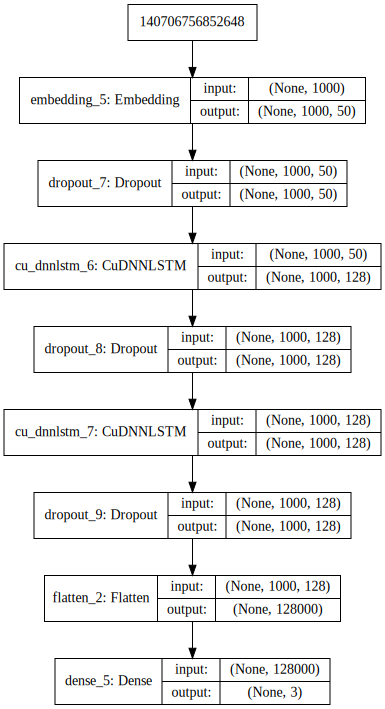

In [27]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [29]:
%%time
epochs = 20
validation_split = 0.2

history = model.fit(x_train, y_train, batch_size=128,
          epochs=epochs, 
          validation_split=validation_split)

Train on 1056 samples, validate on 264 samples
Epoch 1/20
1056/1056 [==============================] - 4s 4ms/step - loss: 0.6317 - acc: 0.5966 - val_loss: 0.6229 - val_acc: 0.5644
Epoch 2/20
1056/1056 [==============================] - 4s 4ms/step - loss: 0.6116 - acc: 0.5890 - val_loss: 0.6535 - val_acc: 0.5720
Epoch 3/20
1056/1056 [==============================] - 4s 4ms/step - loss: 0.6144 - acc: 0.5852 - val_loss: 0.6290 - val_acc: 0.5833
Epoch 4/20
1056/1056 [==============================] - 4s 4ms/step - loss: 0.6085 - acc: 0.6080 - val_loss: 0.6755 - val_acc: 0.4924
Epoch 5/20
1056/1056 [==============================] - 4s 4ms/step - loss: 0.6206 - acc: 0.6136 - val_loss: 0.6152 - val_acc: 0.5985
Epoch 6/20
1056/1056 [==============================] - 4s 4ms/step - loss: 0.6182 - acc: 0.5947 - val_loss: 0.6388 - val_acc: 0.5720
Epoch 7/20
1056/1056 [==============================] - 4s 4ms/step - loss: 0.6027 - acc: 0.6345 - val_loss: 0.6648 - val_acc: 0.5720
Epoch 8/20
1056

In [30]:
loss, acc = model.evaluate(x_val,y_val, verbose = 2, batch_size = 128)
print("Validation Loss: %.2f" % (loss))
print("Validation Accuracy: %.2f" % (acc*100))

Validation Loss: 0.61
Validation Accuracy: 64.44


[[ 18   8  14]
 [ 64  42  16]
 [ 47  18 102]]


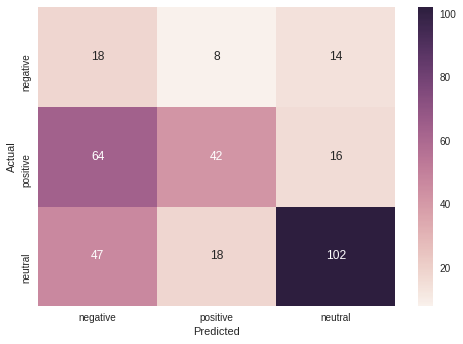

In [31]:
# Predicting the Test set results
y_pred = model.predict(x_val)
# cutoff 0.5
y_pred = (y_pred > 0.5)

y_pred = y_pred.astype(int)


# Confusion matrix 
cm = confusion_matrix(y_val.argmax(axis=1), y_pred.argmax(axis=1))
print(cm)

LABELS = ['negative', 'positive','neutral']
sns.heatmap(cm, annot=True, xticklabels=LABELS, yticklabels=LABELS, fmt='g')
xl = plt.xlabel("Predicted")
yl = plt.ylabel("Actual")